This is just to continue the work halfway after some cleanup


In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz

%matplotlib inline

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name= uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
    
    

In [108]:
#edit _add_ to allow adding numbers, __mult__ to multiply numbers. We edit the code so both other and value

#2 * a won't work if we just change the code to other, we add the function __rmul__ for this that checks if the other way works

#adding also exponential and x^k (if k = -1, we transform x into the divisor, so we can implement divide with less code)

#adding also substraction

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label= label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__ (self, other): #other + self
        return self + other
    
    def __neg__(self):
        return self *-1
    
    def __sub__(self, other): #self - other
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward    
        return out
    
    def __rmul__ (self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/floats for now"
        out = Value(self.data**other, (self,), f'**{other}')             
        def _backward():
            self.grad +=  other* (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # self /other
        return self * other**-1
    
    def tanh(self):
        x= self.data
        
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x= self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data *out.grad
        out._backward = _backward
        return out
    
        
    def backward(self):

        topo = []
        visited= set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                        build_topo(child)
                topo.append(v)     
        build_topo(self)
          #change o to self to make it universal      
        self.grad =1.0
        for node in reversed(topo):
            node._backward()
            


In [110]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(data=6.0)

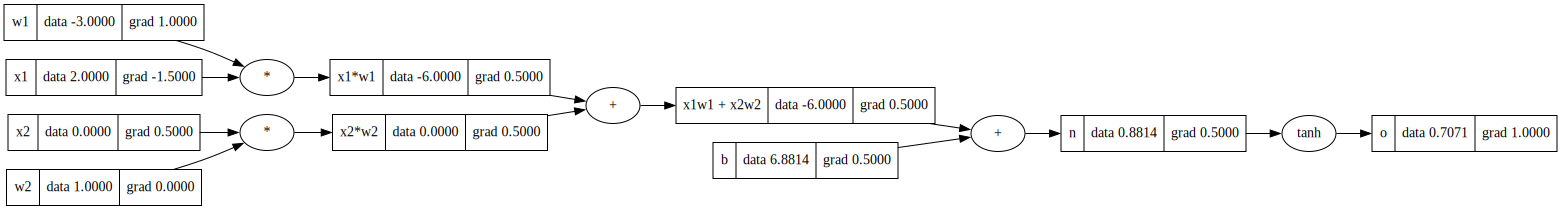

In [112]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813737, label='b')

#inputs * weights and adding the bias
x1w1 = x1 *w1; x1w1.label = 'x1*w1'
x2w2 = x2 *w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#adding activation, need to implement tanh  back to defining Value object
o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)

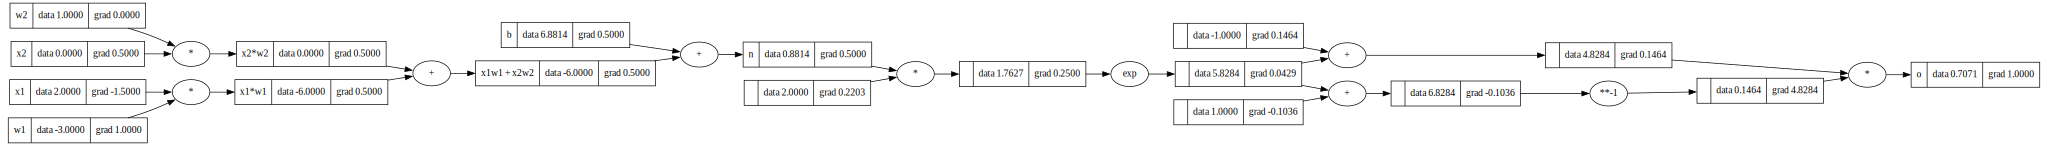

In [116]:
#if we fully implement tanh equation, the graph gets bigger, but the gradients of the original operations are conserved.

#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813737, label='b')

#inputs * weights and adding the bias
x1w1 = x1 *w1; x1w1.label = 'x1*w1'
x2w2 = x2 *w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#----
e= (2*n).exp()
o = (e -1)/(e +1);o.label='o'

#----
o.backward()
draw_dot(o)

In [132]:
#using pytorch to create the very same network and learn how to use this tool
import torch

x1 = torch.Tensor([2.0]).double()  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()  ; w2.requires_grad = True
b = torch.Tensor([6.8813735]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
#o.item()works the same in PyTorch
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

#by default, grad is deactivated for efficiency purposes

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [130]:
#normally we create tensors with this formula:

torch.Tensor([[1,2,3],[4,5,6]]).dtype
#by default pytorch uses float32, hence we add double in the previous cell to be the same as Python

torch.Tensor([[1,2,3],[4,5,6]]).double().dtype

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)

In [133]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [269]:
#lets gonna create a Neuron class compatible with PyTorch that applies forward

class Neuron:
    #Neuron uses two inputs: nin is number of inputs, and matches (not necessarily)t he number of elements of input x
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self,x):
        #this code implements the forward pass, w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w,x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
#to implement a single neuron, firstly we call the number of inputs, n= Neuron(2), and then call the input, n(x)
#Neuron ignores the rest of X if numx if lenght x > nin, and assumes 0 if nin > lenght(x)

#now we implement a layer of neurons. 'nouts' is the number of outputs (neurons) in the layer. 
#layer requires two inputs: number of inputs and number of neurons

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

    #multilayer perceptrop receives number of inputs,  number of output layers (nouts)
class MLP:
    
    def __init__ (self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range (len(nouts))]
    
    def __call__ (self, x):
        for layer in self.layers:
            x= layer(x)
        return x
    
#in this call, three inputs, two hidden layers of 4 neurons each, and 1 output.    
x= [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)



Value(data=0.4136565292394216)

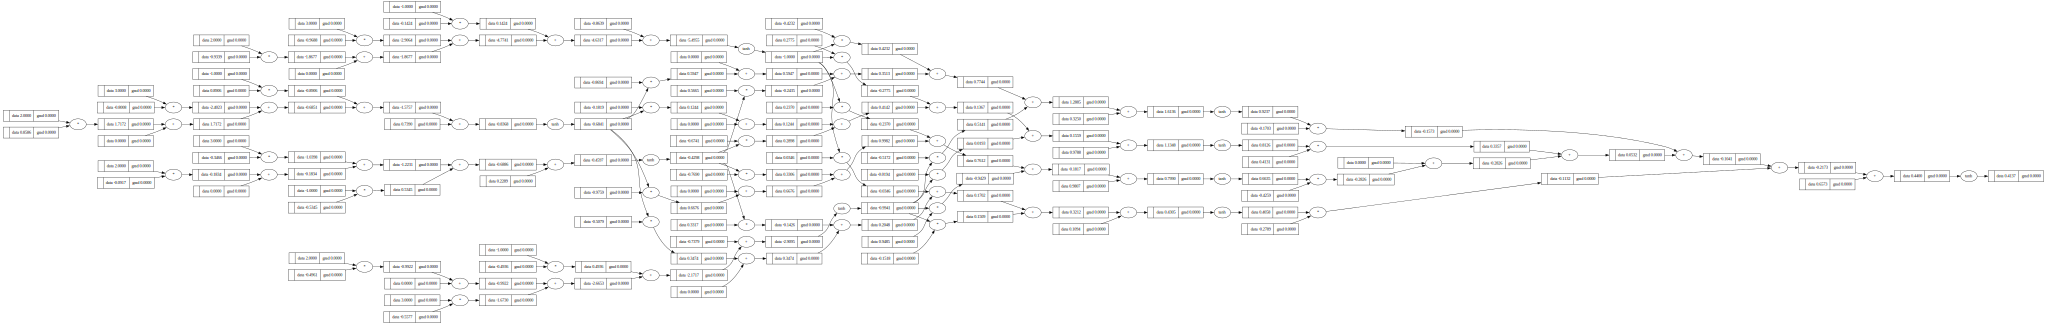

In [271]:
  
draw_dot(n(x))

In [280]:
#creating a simple dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys= [1.0, -1.0, -1.0, 1.0]  #desired targets
ypred = [n(x)  for x in xs]
ypred

[Value(data=0.4136565292394216),
 Value(data=0.8385183133423397),
 Value(data=0.8503892944650556),
 Value(data=0.6050516094613102)]

In [283]:
#less define loss to account for the total accuracy of our network

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.303873026458712)

In [284]:
loss.backward()


In [287]:
#inspecting parameters
n.layers[0].neurons[0].w[0].grad


-0.5255436734233662

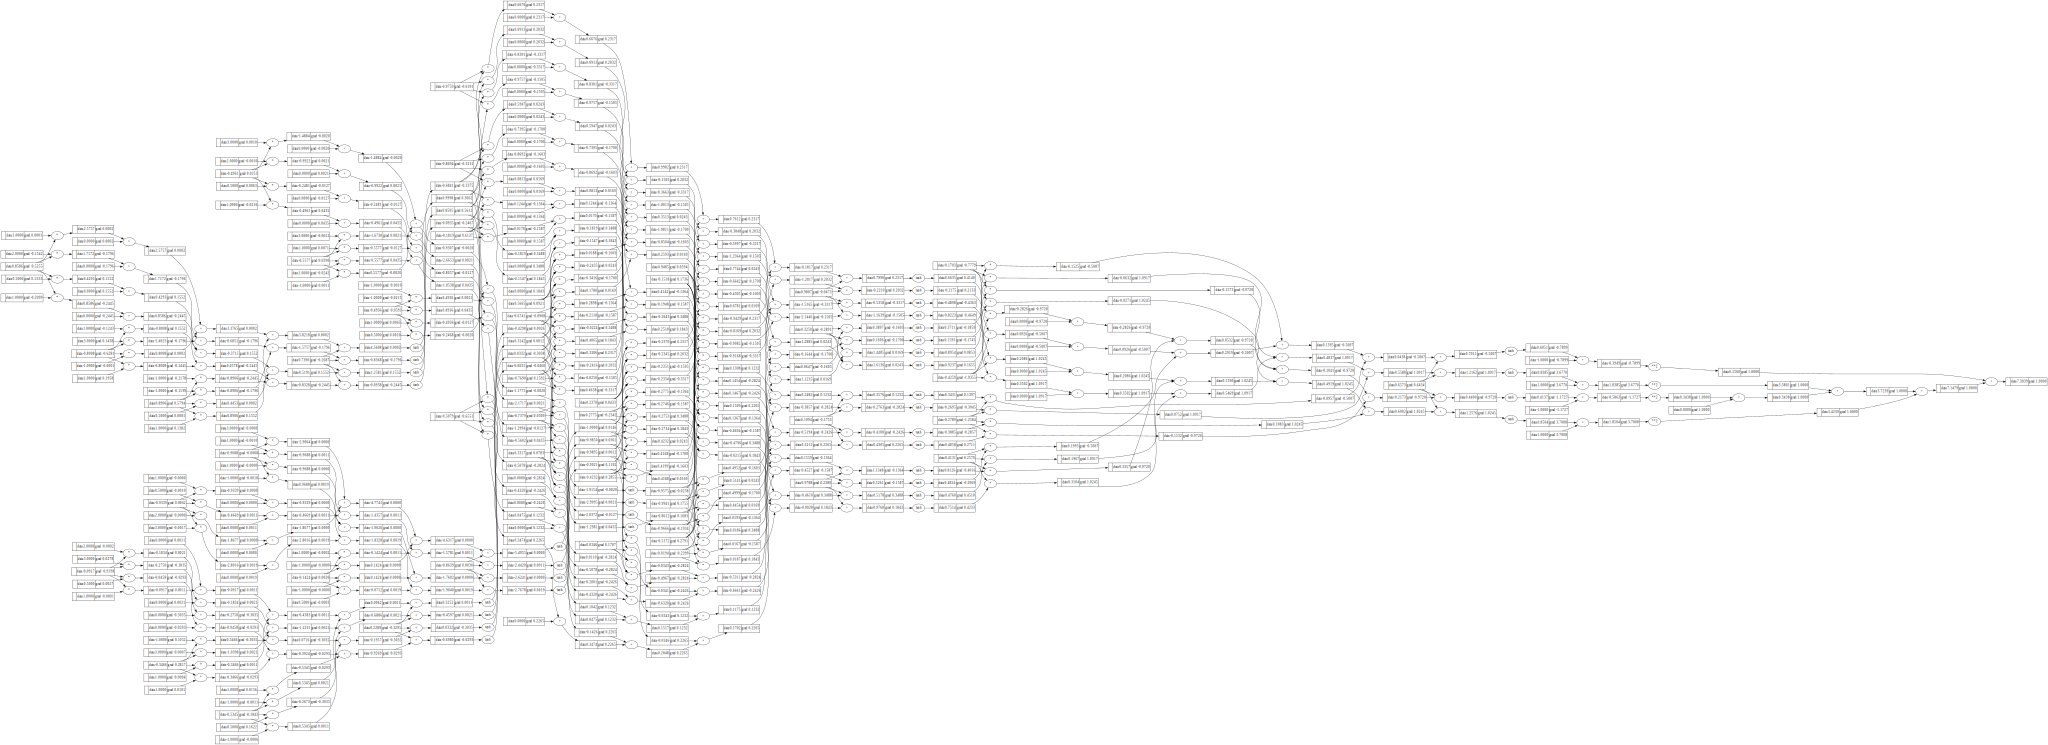

In [288]:
draw_dot(loss)